<a href="https://colab.research.google.com/github/gubbriaco/FPGA-VHDL-Wallace-multiplier/blob/main/potholes_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Potholes Detection using Convolutional Neural Networks (CNNs)
## Overview
This notebook explores the application of Convolutional Neural Networks (CNNs) for pothole detection in road images. The model is developed and trained using Google Colab, a cloud-based Jupyter notebook environment, and leverages a dataset available in the Google Drive directory `/datasets/kaggle/pothole-detection-dataset/`.

## Dataset
The dataset used for this project is sourced from Kaggle and is accessible in the Google Drive folder mentioned above. It includes a collection of images annotated for pothole presence, serving as the training and testing data for the CNN model.

## Tools and Libraries
- Google Colab: A cloud-based platform for developing and running Jupyter notebooks.
- TensorFlow and Keras: Deep learning frameworks used for building and training the CNN model.
- Google Drive: Storage and access to the dataset.

## Notebook Structure
1. Loading and Preprocessing the Dataset
2. Model Architecture
3. Training the CNN Model
4. Evaluation and Testing
5. Results and Analysis

## Setup
To run this notebook, ensure that you have access to Google Colab and the necessary permissions to link to the dataset stored in the specified Google Drive path.

### Dataset Link
[Google Drive - Pothole Detection Dataset](https://drive.google.com/drive/folders/your_dataset_folder_path)

In [45]:
!pip install tensorflow

In [1]:
!nvidia-smi

Fri Jan 19 23:11:01 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P8              11W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [36]:
import os
import pathlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
sns.set()

import warnings
warnings.filterwarnings("ignore")

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import image
from tensorflow import keras
from keras import layers,Sequential,Input

import tensorflow_hub as hub

In [49]:
# Define the paths to your dataset subfolders
data_directory = pathlib.Path('/content/drive/MyDrive/datasets/kaggle/pothole-detection-dataset/')
class_names = [item.name for item in data_directory.glob('*')][:2]
print(f'class_names = {class_names}')

# Define the batch size
batch_size = 32

# Desidered image size
image_size_x = 224
image_size_y = 224


data_gen = ImageDataGenerator(rescale = 1/255., validation_split = 0.2)

train_data = data_gen.flow_from_directory(
    data_directory,
    target_size = (image_size_x, image_size_y),
    batch_size = batch_size,
    subset = 'training',
    class_mode = 'binary'
)
val_data = data_gen.flow_from_directory(
    data_directory,
    target_size = (image_size_x, image_size_y),
    batch_size = batch_size,
    subset = 'validation',
    class_mode = 'binary'
)

class_names = ['potholes', 'normal']
Found 546 images belonging to 2 classes.
Found 135 images belonging to 2 classes.


In [46]:
images, labels = train_data.next()
len(images), len(labels), images[0].shape

(32, 32, (224, 224, 3))

In [47]:
def plot_random_images():
    """
    Plots 20 Random Images from the dataset
    """

    images, labels = train_data.next()
    labels = labels.astype('int32')
    i = 1

    plt.figure(figsize = (10, 10))

    for image, label in zip(images, labels):
        plt.subplot(4, 5, i)
        plt.imshow(image)
        plt.title(class_names[label])
        plt.axis('off')
        i += 1
        if i == 21:
            break

    plt.tight_layout()
    plt.show()

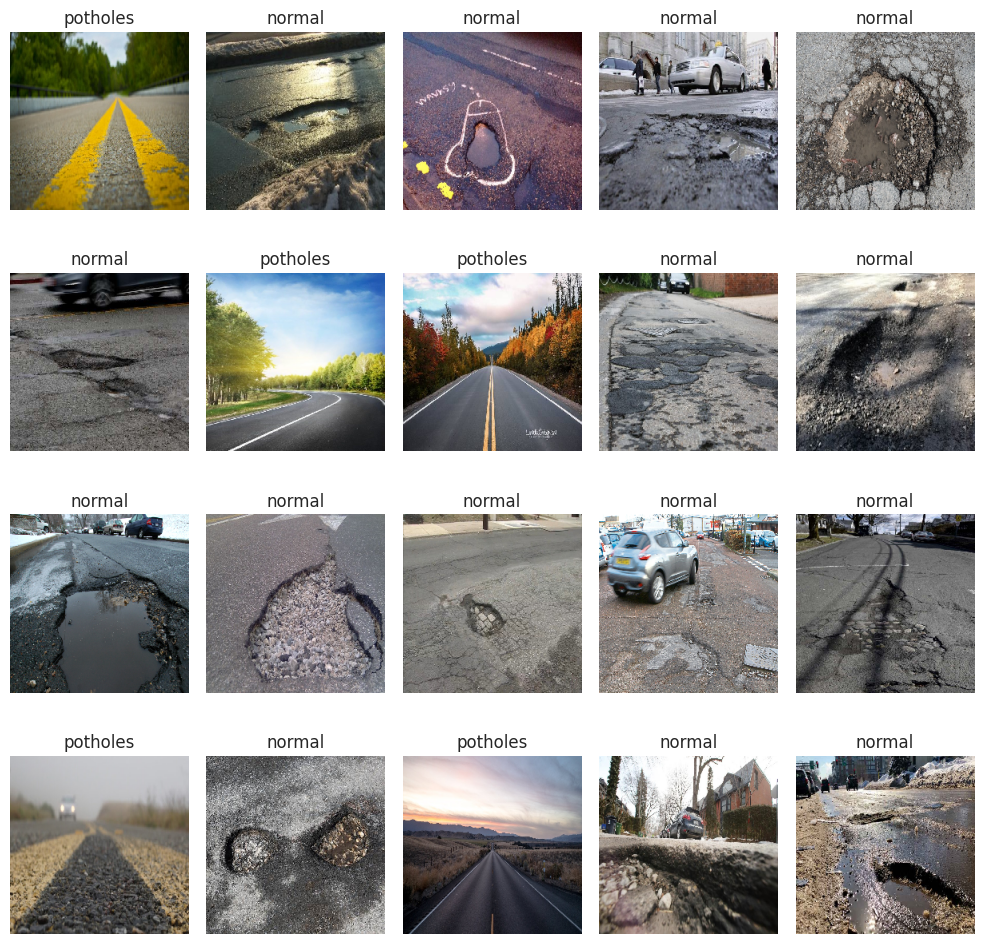

In [48]:
plot_random_images()

In [ ]:
# Define the batch size
batch_size = 32

# Desidered image size
image_size_x = 256
image_size_y = 256


# useful for getting number of output classes
folders = glob(f'{data_directory}/train/*')

# Use the Image Data Generator to import the images from the dataset

train_datagen = ImageDataGenerator(
    rescale = 1./255,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True
)
test_datagen = ImageDataGenerator(rescale = 1./255)

training_dataset = train_datagen.flow_from_directory(
    f'{data_directory}/train/',
    target_size = (224, 224),
    batch_size = 32,
    class_mode = 'categorical'
)
testing_dataset = test_datagen.flow_from_directory(
    f'{data_directory}/test/',
    target_size = (224, 224),
    batch_size = 32,
    class_mode = 'categorical'
)


# Define the class names
class_names = training_dataset.class_names
print(f'class_names = {class_names}')

In [116]:
# Input image size
input_size = (image_size_x, image_size_y, 3)

# Load a pre-trained neural network base (e.g. ResNet50) without fully connected layers
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_size)

# Freezes the weights of the base model
base_model.trainable = False

# Creating the modified RetinaNet network for binary classification
input_tensor = keras.Input(shape=input_size)
x = base_model(input_tensor)
x = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.GlobalAveragePooling2D()(x)  # Reduce spatial dimensions before fully connected layer
x = layers.Dense(256, activation='relu')(x)
x = layers.BatchNormalization()(x)

output = layers.Dense(len(folders), activation= 'softmax')(x)

model = keras.Model(
    inputs=input_tensor,
    outputs=output
)

# Optimiser and metrics configuration
optimizer = tf.keras.optimizers.Adam(
    learning_rate=1e-4
)
model.compile(
    optimizer=optimizer,
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Displays the structure of the model
'''
Total params -> It represents the total number of parameters in the model, which
is the sum of all weights and biases in the various layers.

Trainable params -> It represents the number of parameters that will be trained
during the model training process. In this case, it is 5,376,513 parameters.

Non-trainable params -> This represents the number of parameters that will not
be trained because they are part of the pre-trained ResNet50 model and have been
frozen. In this case, it is 23,589,248 parameters.
 '''
model.summary()

Model: "model_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_34 (InputLayer)       [(None, 256, 256, 3)]     0         
                                                                 
 resnet50 (Functional)       (None, 8, 8, 2048)        23587712  
                                                                 
 conv2d_32 (Conv2D)          (None, 8, 8, 256)         4718848   
                                                                 
 batch_normalization_48 (Ba  (None, 8, 8, 256)         1024      
 tchNormalization)                                               
                                                                 
 conv2d_33 (Conv2D)          (None, 8, 8, 256)         590080    
                                                                 
 batch_normalization_49 (Ba  (None, 8, 8, 256)         1024      
 tchNormalization)                                        

In [117]:
epochs = 10
batch_size = 32


# Model training
history = model.fit(
    training_dataset,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=validation_dataset
)


'''
After training, you can evaluate the performance of the model on the test set
using the evaluate method
'''
num_test_images = 200  # Specifica il numero di immagini che desideri nel test dataset
test_dataset = Utils.create_test_dataset(training_dataset, num_test_images)
test_loss, test_accuracy = model.evaluate(test_dataset)
print(f'Test Loss: {test_loss}, Test Accuracy: {test_accuracy}')

Epoch 1/10


InvalidArgumentError: Graph execution error:

Detected at node decode_image/DecodeImage defined at (most recent call last):
<stack traces unavailable>
Detected at node decode_image/DecodeImage defined at (most recent call last):
<stack traces unavailable>
2 root error(s) found.
  (0) INVALID_ARGUMENT:  Unknown image file format. One of JPEG, PNG, GIF, BMP required.
	 [[{{node decode_image/DecodeImage}}]]
	 [[IteratorGetNext]]
	 [[IteratorGetNext/_4]]
  (1) INVALID_ARGUMENT:  Unknown image file format. One of JPEG, PNG, GIF, BMP required.
	 [[{{node decode_image/DecodeImage}}]]
	 [[IteratorGetNext]]
0 successful operations.
0 derived errors ignored. [Op:__inference_train_function_135999]